# Collecting data from a Liander Smart Energy Meter 
Dutch: Uitlezen van de Slimme Meter van Liander

Author: Marcel van den Bosch (email: marcel@marcel.im)

Date:06-Jun-2018

In [25]:
import sys
import serial
import re

In [73]:
ser = serial.Serial()
ser.baudrate = 115200
ser.bytesize=serial.EIGHTBITS
ser.parity=serial.PARITY_NONE
ser.stopbits=serial.STOPBITS_ONE
ser.xonxoff=0
ser.rtscts=0
ser.timeout=20
ser.port="/dev/ttyUSB0"

In [74]:
#Open COM port
try:
    ser.open()
except:
    print ("Fout bij het openen van %s. Programma afgebroken."  % ser.name)

In [234]:
def getSmartMeterData(inSerial,printOutput = False,verbose = False):
    buffer=[]
    telegram_start = False;
    # Empty dict
    data = {}
    
    while True:
        p1_line_in=''
        
        try:
            p1_raw = ser.readline()
        except:
            print ("Error reading from port." % ser.name )
            return(False)
        
        p1_str=str(p1_raw, "utf-8")
        p1_line_in=p1_str.strip()
        
        if telegram_start == False:
            if len(p1_line_in) >0:
                if p1_line_in[0] == "/":
                    buffer.append(p1_line_in)
                    if verbose == True: print ("Line:",p1_line_in)
                    telegram_start = True
        else:
            buffer.append(p1_line_in)
            if verbose == True: print ("Line:",p1_line_in)
            
            if len(p1_line_in) >0:
                if p1_line_in[0] == "!":
                    telegram_start = False
                    if len(buffer) == 26:
                        break
                    else:
                        print("Missed packet, expected length %i got %i -> Retrying!" % (26,len(buffer)))
                        buffer = []

    for line in buffer:
        if re.search("1-0:1.8.1", line):
            data['READING_POWER_IN_LOW_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1));
            if printOutput == True: print("Meter Reading electricity delivered to client (low tariff) in 0,001 kWh:\t\t%.3f kWh" %
                                     float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:1.8.2", line):
            data['READING_POWER_IN_NORM_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1));
            if printOutput == True: print("Meter Reading electricity delivered to client (normal tariff) in 0,001 kWh:\t\t%.3f kWh" %
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:2.8.1", line):
            data['READING_POWER_OUT_LOW_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Meter Reading electricity delivered by client (low tariff) in 0,001 kWh:\t\t%.3f kWh" % 
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:2.8.2", line):
            data['READING_POWER_OUT_NORM_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Meter Reading electricity delivered by client (normal tariff) in 0,001 kWh:\t\t%.3f kWh" %
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:1.7.0", line):
            data['ACTUAL_POWER_IN'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Actual electricity power delivered (+P) in 1 Watt resolution:\t\t\t\t%.3f kW" % 
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))        
        elif re.search("1-0:2.7.0", line):
            data['ACTUAL_POWER_OUT'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Actual electricity power received (-P) in 1 Watt resolution:\t\t\t\t%.3f kW" %
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))        
        # Gasmeter: 0-1:24.3.0
        elif re.search("0-1:24.2.1", line):
            data['READING_GAS_IN'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Gas Data - Gas delivered to client in m3:\t\t\t\t\t\t%.3f m3" %
                                     float(re.search(r'\(([\d\.]*)\*', line).group(1)))                
       # else:
               # pass
    buffer = []
    return(data)

In [248]:
getSmartMeterData(ser,printOutput = True)

Meter Reading electricity delivered to client (low tariff) in 0,001 kWh:		10.060 kWh
Meter Reading electricity delivered to client (normal tariff) in 0,001 kWh:		12.212 kWh
Meter Reading electricity delivered by client (low tariff) in 0,001 kWh:		0.000 kWh
Meter Reading electricity delivered by client (normal tariff) in 0,001 kWh:		0.000 kWh
Actual electricity power delivered (+P) in 1 Watt resolution:				2.795 kW
Actual electricity power received (-P) in 1 Watt resolution:				0.000 kW
Gas Data - Gas delivered to client in m3:						2.228 m3


{'ACTUAL_POWER_IN': 2.795,
 'ACTUAL_POWER_OUT': 0.0,
 'READING_GAS_IN': 2.228,
 'READING_POWER_IN_LOW_TARIFF': 10.06,
 'READING_POWER_IN_NORM_TARIFF': 12.212,
 'READING_POWER_OUT_LOW_TARIFF': 0.0,
 'READING_POWER_OUT_NORM_TARIFF': 0.0}

## Measure actual power consumption over a brief moment in time

In [169]:
import time
import datetime
import numpy as np
import pandas as pd

In [249]:
no_iter = 10 * (60/15) # 10 minutes with 15 seconds between each iteration

In [250]:
i = 0;
ts = list()
data = []

while i < no_iter:
    data = getSmartMeterData(ser)
    ts.append([datetime.datetime.now(),data['ACTUAL_POWER_IN']])
    time.sleep(15)
    i = i+1
    pass

Missed packet, expected length 26 got 6 -> Retrying!
Missed packet, expected length 26 got 32 -> Retrying!
Missed packet, expected length 26 got 6 -> Retrying!
Missed packet, expected length 26 got 33 -> Retrying!
Missed packet, expected length 26 got 6 -> Retrying!


In [291]:
df = pd.DataFrame.from_dict(ts)
df.columns = ['datetime', 'value']
df.set_index('datetime')
df.head(5)

,datetime,value
0,2018-06-06 17:30:28.698713,2.795
1,2018-06-06 17:30:43.720277,2.795
2,2018-06-06 17:30:58.738647,2.792
3,2018-06-06 17:31:13.753747,2.792
4,2018-06-06 17:31:28.769283,2.792


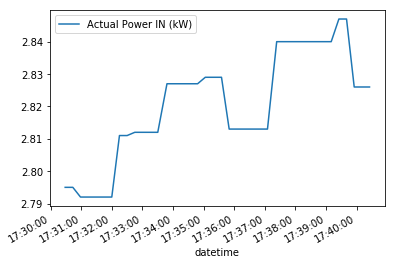

In [289]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.xaxis_date(tz=None)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

df.plot(x='datetime',y='value',label='Actual Power IN (kW)',ax=ax)

In [290]:
#Close port and show status
try:
    ser.close()
except:
    print ("Fout: %s." % ser.name )